In [1]:
!pip install tensorflow

In [2]:
pip install --upgrade tensorflow

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_classification/uci-news-aggregator.csv')
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [7]:
data = data[['TITLE', 'CATEGORY']]
data.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [8]:
data.shape

(422419, 2)

In [9]:
data['TITLE'].unique()

array(['Fed official says weak data caused by weather, should not slow taper',
       "Fed's Charles Plosser sees high bar for change in pace of tapering",
       'US open: Stocks fall after Fed official hints at accelerated tapering',
       ...,
       'Child who swallowed battery to have reconstructive surgery at Cincinnati  ...',
       'Phoenix boy undergoes surgery to repair throat damage - WFSB 3 Connecticut',
       'Phoenix boy undergoes surgery to repair throat damage - CBS 3 Springfield  ...'],
      dtype=object)

In [10]:
data['CATEGORY'].unique()

array(['b', 't', 'e', 'm'], dtype=object)

In [11]:
data.isnull().sum()

,0
TITLE,0
CATEGORY,0


In [12]:
data['CATEGORY'].value_counts()

,count
CATEGORY,
e,152469
b,115967
t,108344
m,45639


In [13]:
# Shuffling data as same class rows are grouped together
n_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))

# taking equal (45000) no. of rows/categories for each class & creating separate dataframes for each class
e = shuffled[shuffled['CATEGORY']=='e'][:n_categories]
b = shuffled[shuffled['CATEGORY']=='b'][:n_categories]
t = shuffled[shuffled['CATEGORY']=='t'][:n_categories]
m = shuffled[shuffled['CATEGORY']=='m'][:n_categories]

concat_data = pd.concat([e,b,t,m], ignore_index=True) # concats the four dataframes vertical

# Shuffle the dataset again
concat_data = concat_data.reindex(np.random.permutation(concat_data.index))
concat_data.head()
print(concat_data.shape)

# This shuffling increases generalization

(180000, 2)


In [14]:
from tensorflow.keras.utils import to_categorical

concat_data.loc[concat_data['CATEGORY']=='e', 'LABEL'] = 0
concat_data.loc[concat_data['CATEGORY']=='b', 'LABEL'] = 1
concat_data.loc[concat_data['CATEGORY']=='t', 'LABEL'] = 2
concat_data.loc[concat_data['CATEGORY']=='m', 'LABEL'] = 3

print(concat_data['LABEL'][:10])

labels = to_categorical(concat_data['LABEL'], num_classes=4)
print(labels[:10])

if 'CATEGORY' in concat_data.keys():
  concat_data.drop(['CATEGORY'], axis=1, inplace=True)

print(concat_data.head())
print(concat_data.shape)

49944     1.0
152921    3.0
22095     0.0
39472     0.0
25725     0.0
64086     1.0
30046     0.0
81477     1.0
59757     1.0
104294    2.0
Name: LABEL, dtype: float64
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
                                                    TITLE  LABEL
49944   'Nigeria exaggerates its telecom subscriber nu...    1.0
152921  Stricken doctor requests experimental Ebola se...    3.0
22095   'True Detective' Creator Talks Second Season M...    0.0
39472   New Michael Jackson Album, 'XSCAPE,' Coming Fi...    0.0
25725   'Guardians of the Galaxy': Zoe Saldana channel...    0.0
(180000, 2)


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_most_freq_words =  8000
max_length = 130

tokenizer = Tokenizer(num_words=n_most_freq_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_{|}~', lower=True)  # num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tokenizer.fit_on_texts(concat_data['TITLE'].values)  # Updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token.
sequences = tokenizer.texts_to_sequences(concat_data['TITLE'].values)  # Transforms each text in texts to a sequence of integers.
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X = pad_sequences(sequences, maxlen=max_length)
# Pads sequences to the same length.
# This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, maxlen)
# Sequences that are shorter than maxlen are padded with value until they are maxlen long.
# Sequences longer than maxlen are truncated so that they fit the desired length.

print(X)
print(X.shape)

Found 52700 unique tokens
[[   0    0    0 ... 4275 6323 1248]
 [   0    0    0 ... 2206    1  670]
 [   0    0    0 ...  363    9  361]
 ...
 [   0    0    0 ...    1  692 1971]
 [   0    0    0 ... 2827    1 5167]
 [   0    0    0 ...    7    3 1652]]
(180000, 130)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [17]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((135000, 130), (135000, 4), (45000, 130), (45000, 4))


In [18]:
# Hyperparameters
epochs = 10
emb_dim = 128
batch_size = 128

In [21]:
# We can use Embedding in two ways:
# 1) Directly add the Embedding layer in our neural network
# 2) Train our data for embedding prior only and then use that features & weights in the embedding layer of our neural network

# We use (1) here

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(n_most_freq_words, emb_dim))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss')], verbose=1)


# >>> model = tf.keras.Sequential()
# >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
# >>> # The model will take as input an integer matrix of size (batch,
# >>> # input_length), and the largest integer (i.e. word index) in the input
# >>> # should be no larger than 999 (vocabulary size).
# >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
# >>> # dimension.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 269s 315ms/step - acc: 0.5076 - loss: 1.0980 - val_acc: 0.8854 - val_loss: 0.3281
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 316s 307ms/step - acc: 0.8513 - loss: 0.4257 - val_acc: 0.9079 - val_loss: 0.2670
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 265s 310ms/step - acc: 0.8846 - loss: 0.3371 - val_acc: 0.9129 - val_loss: 0.2504
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 322s 311ms/step - acc: 0.8959 - loss: 0.3005 - val_acc: 0.9165 - val_loss: 0.2440
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 263s 312ms/step - acc: 0.9057 - loss: 0.2771 - val_acc: 0.9177 - val_loss: 0.2402
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 272s 322ms/step - acc: 0.9108 - loss: 0.2625 - val_acc: 0.9185 - val_loss: 0.2402


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 1)

print(f'test set loss: {test_loss}, test set accuracy: {test_acc}')

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - acc: 0.9211 - loss: 0.2355
test set loss: 0.23323167860507965, test set accuracy: 0.920977771282196


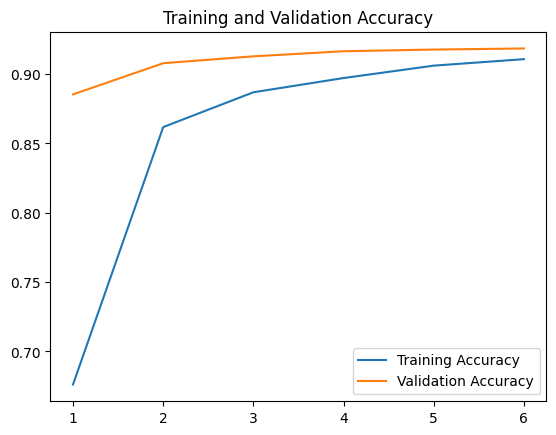

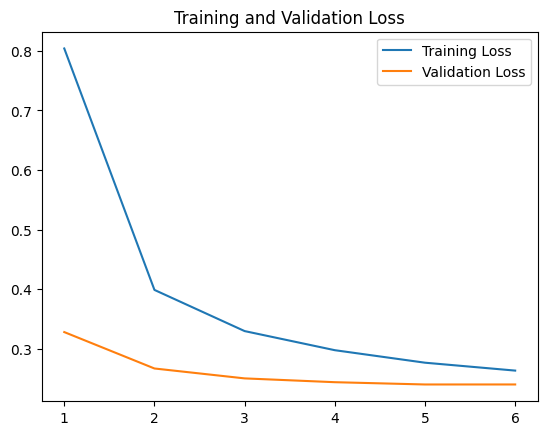

In [26]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, '-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure( )

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, '-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()